In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from pandas import Timestamp
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
Emissions_df = pd.read_csv('/content/CO2_Emissions.csv')

In [4]:
Emissions_df.head(5)

,ISO,Country,Data source,Sector,Gas,Unit,2020,2019,2018,2017,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,CHN,China,GCP,Total fossil fuels and cement,CO2,MtCO₂e,10914.01,10721.04,10353.93,10011.15,...,3557.27,3364.59,3515.59,3508.82,3361.64,3103.74,2921.65,2730.79,2606.10,2484.85
1,CHN,China,GCP,Coal,CO2,MtCO₂e,7679.55,7523.17,7316.40,7163.32,...,2580.99,2444.77,2609.56,2660.40,2569.75,2380.59,2228.75,2114.72,2049.92,1976.68
2,USA,United States,GCP,Total fossil fuels and cement,CO2,MtCO₂e,4714.63,5262.15,5377.80,5212.16,...,5803.92,5733.28,5688.14,5612.98,5425.26,5364.28,5272.85,5174.23,5062.96,5120.96
3,EUU,European Union (27),GCP,Total fossil fuels and cement,CO2,MtCO₂e,2629.97,2904.16,3046.24,3119.78,...,3590.36,3645.83,3655.53,3721.91,3637.06,3590.76,3609.84,3678.62,3804.56,3870.43
4,IND,India,GCP,Total fossil fuels and cement,CO2,MtCO₂e,2421.55,2612.89,2593.06,2426.61,...,950.46,875.77,858.01,823.62,760.46,714.06,677.30,655.45,615.37,578.00


In [5]:
Emissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ISO          120 non-null    object 
 1   Country      120 non-null    object 
 2   Data source  120 non-null    object 
 3   Sector       120 non-null    object 
 4   Gas          120 non-null    object 
 5   Unit         120 non-null    object 
 6   2020         120 non-null    float64
 7   2019         120 non-null    float64
 8   2018         120 non-null    float64
 9   2017         120 non-null    float64
 10  2016         120 non-null    float64
 11  2015         120 non-null    float64
 12  2014         120 non-null    float64
 13  2013         120 non-null    float64
 14  2012         120 non-null    float64
 15  2011         120 non-null    float64
 16  2010         120 non-null    float64
 17  2009         120 non-null    float64
 18  2008         120 non-null    float64
 19  2007    

In [6]:
Emissions_df.describe()

,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,489.942250,514.489417,513.442917,503.742583,498.633917,500.811917,502.207333,501.954000,498.732000,493.011917,...,368.740917,361.139167,364.316417,364.424167,353.457083,346.178500,343.305833,340.007000,344.439667,343.106417
std,1327.831529,1335.587002,1308.992784,1271.796483,1251.538811,1269.149692,1288.258747,1287.320344,1270.396294,1256.414053,...,799.862760,786.902412,792.882822,793.125876,768.982223,750.991911,740.099362,731.143317,736.351935,744.650424
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.632500,20.865000,20.767500,20.787500,21.432500,22.922500,24.695000,24.387500,22.857500,21.490000,...,14.462500,14.257500,14.882500,13.962500,13.925000,13.252500,12.332500,11.295000,11.032500,10.297500
50%,131.855000,145.215000,143.680000,141.365000,139.115000,135.235000,126.025000,137.505000,138.780000,133.065000,...,83.980000,87.270000,85.625000,82.405000,76.980000,78.560000,77.175000,82.220000,87.070000,82.445000
75%,389.317500,415.540000,417.027500,420.842500,413.120000,415.685000,397.715000,401.515000,416.267500,426.142500,...,341.597500,329.587500,337.585000,328.522500,322.432500,328.022500,318.857500,300.265000,281.785000,268.365000
max,10914.010000,10721.040000,10353.930000,10011.150000,9765.030000,9866.950000,9998.670000,9956.380000,9779.350000,9532.410000,...,5803.920000,5733.280000,5688.140000,5612.980000,5425.260000,5364.280000,5272.850000,5174.230000,5062.960000,5120.960000


In [7]:
Emissions_df.isna().any()

ISO            False
Country        False
Data source    False
Sector         False
Gas            False
Unit           False
2020           False
2019           False
2018           False
2017           False
2016           False
2015           False
2014           False
2013           False
2012           False
2011           False
2010           False
2009           False
2008           False
2007           False
2006           False
2005           False
2004           False
2003           False
2002           False
2001           False
2000           False
1999           False
1998           False
1997           False
1996           False
1995           False
1994           False
1993           False
1992           False
1991           False
1990           False
dtype: bool

In [8]:
print(Emissions_df.dtypes)

ISO             object
Country         object
Data source     object
Sector          object
Gas             object
Unit            object
2020           float64
2019           float64
2018           float64
2017           float64
2016           float64
2015           float64
2014           float64
2013           float64
2012           float64
2011           float64
2010           float64
2009           float64
2008           float64
2007           float64
2006           float64
2005           float64
2004           float64
2003           float64
2002           float64
2001           float64
2000           float64
1999           float64
1998           float64
1997           float64
1996           float64
1995           float64
1994           float64
1993           float64
1992           float64
1991           float64
1990           float64
dtype: object


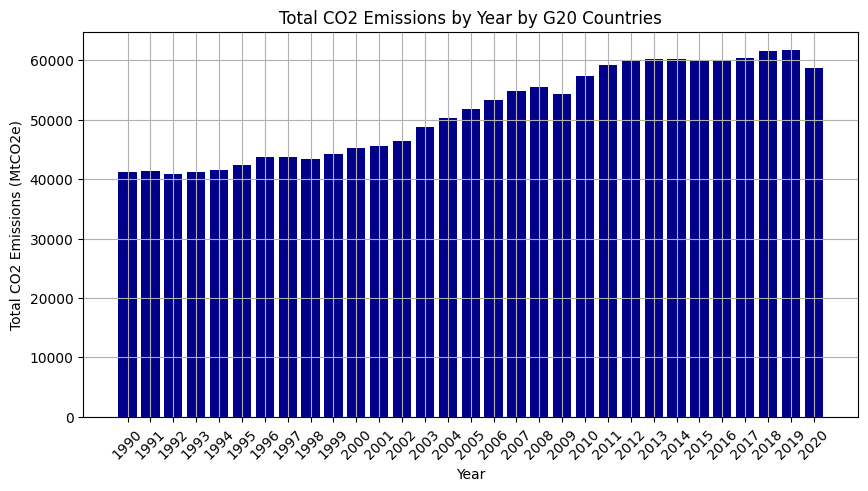

In [9]:
import matplotlib.pyplot as plt
# Drop non-numeric columns
df_numeric = Emissions_df.select_dtypes(include=['float64', 'int64'])

# Sum up emissions by year across all rows
total_emissions_per_year = df_numeric.sum()

# Sort the index to ensure it's in ascending order
total_emissions_per_year.sort_index(inplace=True)

# Plotting the data
plt.figure(figsize=(10, 5))
plt.bar(total_emissions_per_year.index, total_emissions_per_year.values, color='darkblue')
plt.title('Total CO2 Emissions by Year by G20 Countries')
plt.xlabel('Year')
plt.ylabel('Total CO2 Emissions (MtCO2e)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Sector
Cement                           float64
Coal                             float64
Gas                              float64
Gas flaring                      float64
Oil                              float64
Total fossil fuels and cement    float64
dtype: object


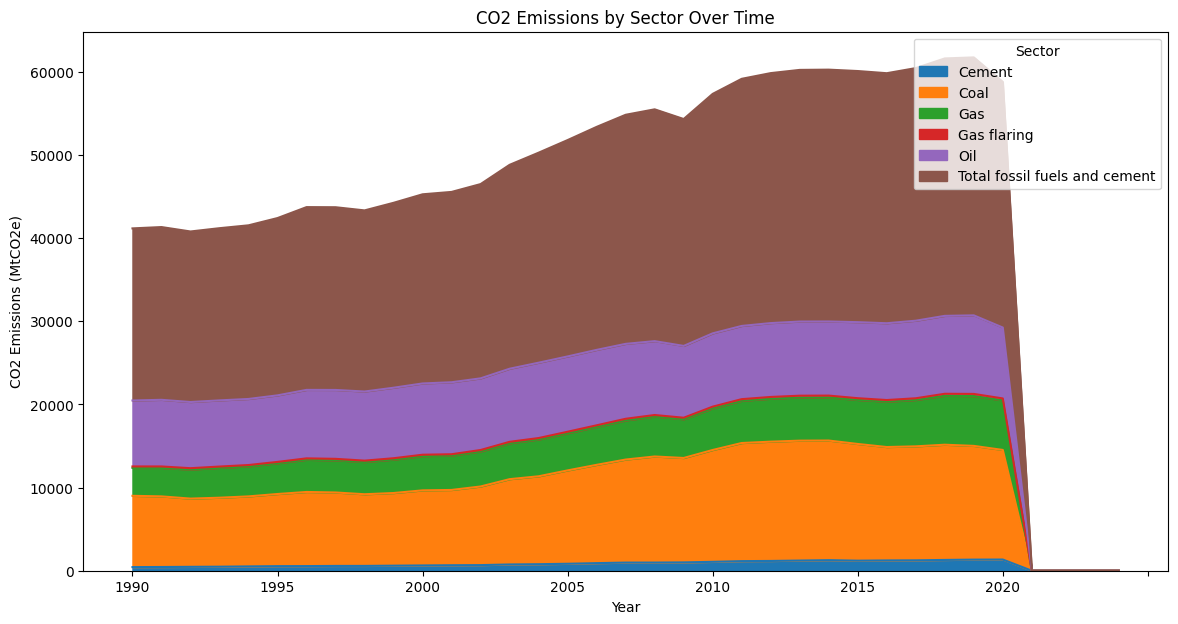

In [10]:
# Melt the DataFrame to long format
df_melted = Emissions_df.melt(id_vars=['Country', 'Sector'], var_name='Year', value_name='CO2_Emissions')

# Ensure all emission data are numeric and handle None/NaN
df_melted['CO2_Emissions'] = pd.to_numeric(df_melted['CO2_Emissions'], errors='coerce').fillna(0)

# Create a pivot table with years as rows and sectors as columns
df_pivot = df_melted.pivot_table(index='Year', columns='Sector', values='CO2_Emissions', aggfunc='sum')

# Check the data types in the pivot table
print(df_pivot.dtypes)  # Ensure all are numeric

# Plotting the stacked area chart
df_pivot.plot(kind='area', stacked=True, figsize=(14, 7))
plt.title('CO2 Emissions by Sector Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (MtCO2e)')
plt.legend(title='Sector', loc='upper right')
plt.show()

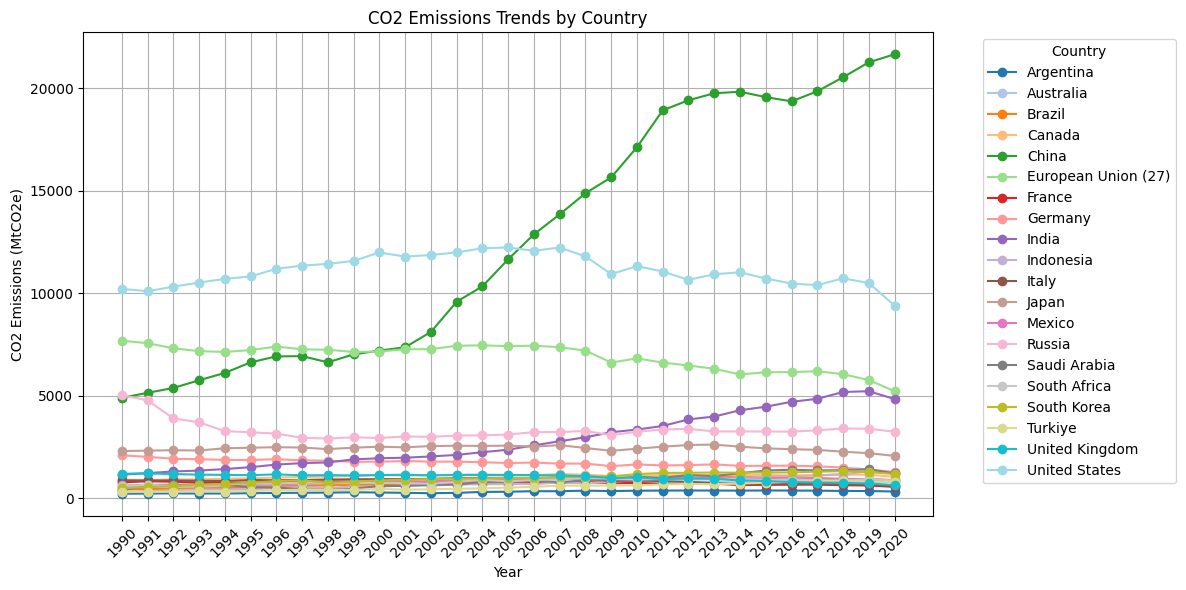

In [11]:
import matplotlib.cm as cm
# Convert emission values to numeric, handling non-numeric issues by coercing to NaN and then filling with zero
for year in ['2020', '2019', '2018']:
    Emissions_df[year] = pd.to_numeric(Emissions_df[year], errors='coerce').fillna(0)

# Melt the DataFrame to long format
df_melted = Emissions_df.melt(id_vars=['Country', 'Sector', 'ISO','Data source', 'Gas', 'Unit'], var_name='Year', value_name='CO2_Emissions')

# Ensure all emission data are numeric before pivoting
df_melted['CO2_Emissions'] = pd.to_numeric(df_melted['CO2_Emissions'], errors='coerce').fillna(0)

# Pivot table with years as rows and countries as columns
df_pivot = df_melted.pivot_table(index='Year', columns='Country', values='CO2_Emissions', aggfunc='sum')

# Plotting each country as a separate line with a unique color
plt.figure(figsize=(12, 6))
colors = cm.tab20.colors  # Get a list of distinct colors from the 'tab20' colormap
for i, column in enumerate(df_pivot.columns):
    plt.plot(df_pivot.index, df_pivot[column], marker='o', label=column, color=colors[i % len(colors)])

plt.title('CO2 Emissions Trends by Country')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (MtCO2e)')
plt.legend(title='Country',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

**Data PreProcessing**

In [12]:
# Assuming the structure has a 'Country' column and year columns from '1990' to '2020'
year_columns = [str(year) for year in range(1990, 2021)]  # Create a list of year columns
data_long = pd.melt(Emissions_df, id_vars=['Country'], value_vars=year_columns, var_name='Year', value_name='Emissions')

# Convert 'Year' to datetime
data_long['Year'] = pd.to_datetime(data_long['Year'], format='%Y')

# Group by Country and Year to sum emissions, and fill NaNs with zero if there are any
yearly_totals = data_long.groupby(['Country', 'Year']).agg({'Emissions': 'sum'}).reset_index()

# Pivot to wide format with years as rows and countries as columns
final_df = yearly_totals.pivot(index='Year', columns='Country', values='Emissions').fillna(0)

final_df

Country,Argentina,Australia,Brazil,Canada,China,European Union (27),France,Germany,India,Indonesia,Italy,Japan,Mexico,Russia,Saudi Arabia,South Africa,South Korea,Turkiye,United Kingdom,United States
Year,,,,,,,,,,,,,,,,,,,,
1990-01-01,224.16,554.00,433.62,913.87,4905.63,7691.51,781.86,2098.55,1156.00,310.16,872.89,2303.13,634.08,5034.72,417.00,625.86,498.07,300.25,1200.05,10217.36
1991-01-01,235.01,556.76,455.04,897.05,5144.14,7565.76,830.67,2023.67,1230.72,349.73,871.73,2326.88,660.26,4778.03,577.10,652.05,547.85,313.33,1215.36,10101.62
1992-01-01,242.46,566.62,463.25,925.04,5383.99,7316.93,811.03,1929.05,1310.90,398.84,872.44,2347.33,665.56,3901.94,632.35,602.66,596.06,325.84,1184.25,10324.30
1993-01-01,235.55,575.10,484.37,926.15,5757.45,7179.42,772.33,1908.86,1354.60,430.21,857.29,2333.61,676.14,3709.96,681.28,640.69,656.08,339.22,1156.21,10522.18
1994-01-01,236.94,584.32,503.91,954.81,6117.73,7139.88,758.42,1875.84,1428.13,438.74,845.99,2443.88,703.69,3277.22,667.29,677.39,707.09,331.85,1144.40,10703.90
1995-01-01,250.49,607.13,533.25,980.43,6630.43,7230.76,768.02,1869.20,1520.91,444.81,893.87,2468.58,662.28,3221.77,536.26,723.39,762.72,359.30,1128.33,10822.92
1996-01-01,262.26,620.77,574.37,1013.17,6922.74,7401.76,801.00,1909.26,1647.25,506.14,882.68,2493.68,683.53,3158.27,526.65,727.46,837.33,396.15,1169.39,11197.04
1997-01-01,273.05,637.35,609.55,1041.69,6935.56,7268.02,786.03,1852.80,1716.02,559.88,894.19,2479.06,725.36,2950.54,443.34,770.44,885.10,420.66,1121.99,11347.34
1998-01-01,278.01,664.78,630.58,1057.18,6634.62,7248.41,822.88,1836.92,1751.55,489.05,918.69,2399.82,762.62,2918.62,426.31,754.53,751.51,420.81,1133.21,11436.60


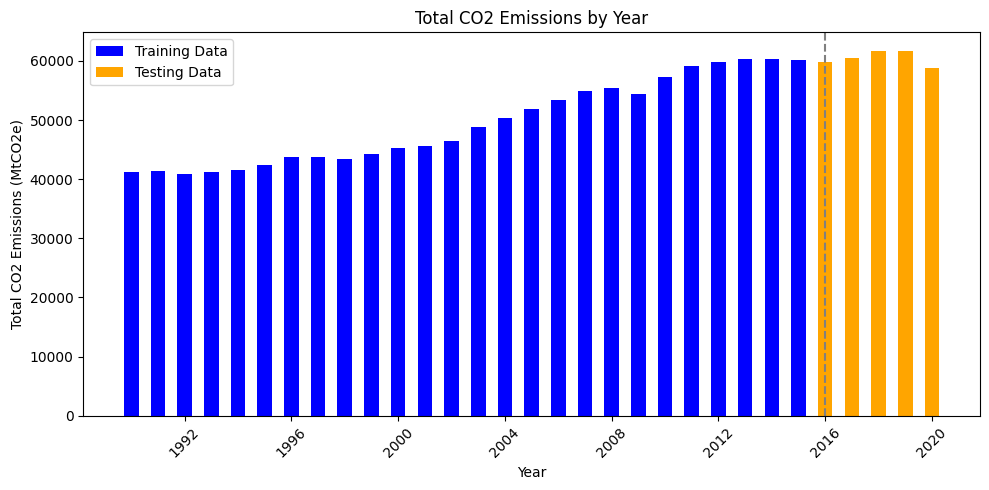

In [13]:
# Calculate the total CO2 emissions for each year across all countries
total_emissions = final_df.sum(axis=1)

# Split the data into training (1980-2015) and testing (2016-2020)
train_data = total_emissions[:'2015']
test_data = total_emissions['2016':]

# Plot the data
plt.figure(figsize=(10, 5))
bar_width = 200  # Adjusted bar width to prevent overlap
plt.bar(train_data.index, train_data.values, width=bar_width, label='Training Data', color='blue')
plt.bar(test_data.index, test_data.values, width=bar_width, label='Testing Data', color='orange')
plt.axvline(x=Timestamp('2015-12-31'), color='gray', linestyle='--')  # Mark the split point
plt.title('Total CO2 Emissions by Year')
plt.xlabel('Year')
plt.ylabel('Total CO2 Emissions (MtCO2e)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# AutoRegressive Integrated Moving Average MODEL

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


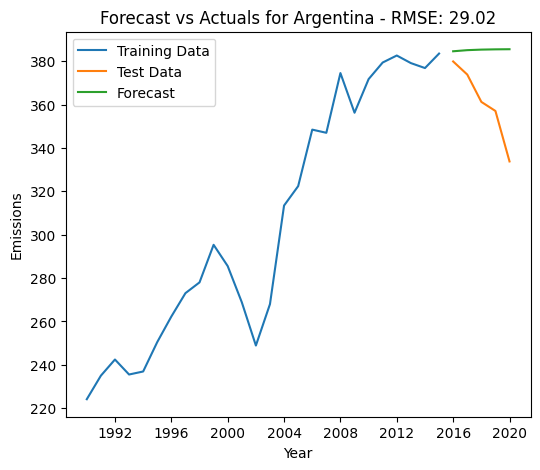

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

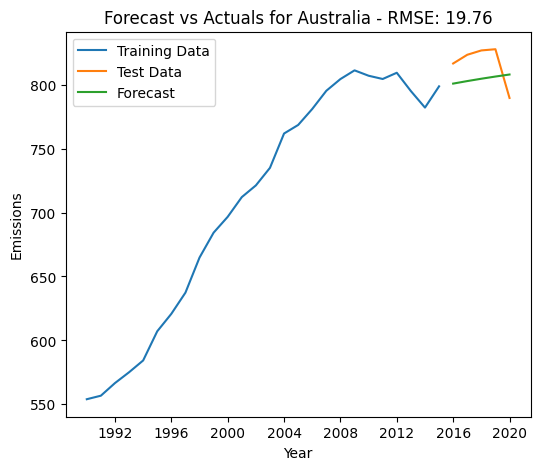

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 640x480 with 0 Axes>

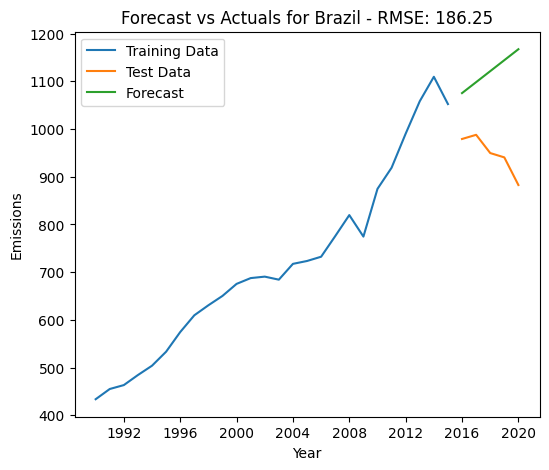

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

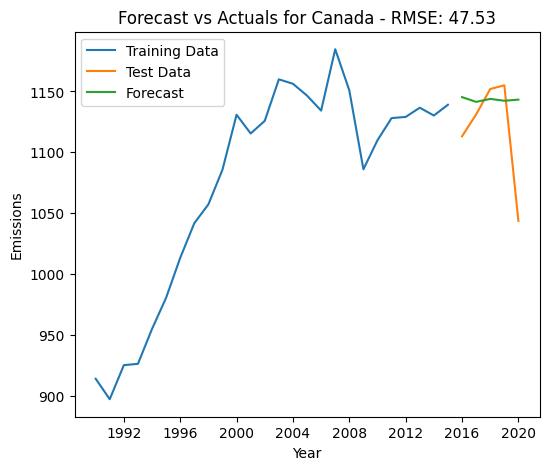

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

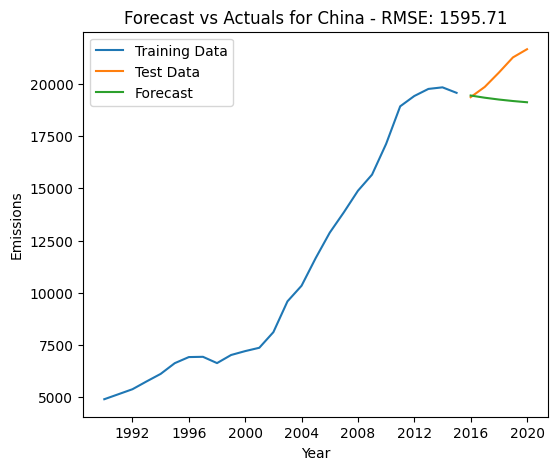

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

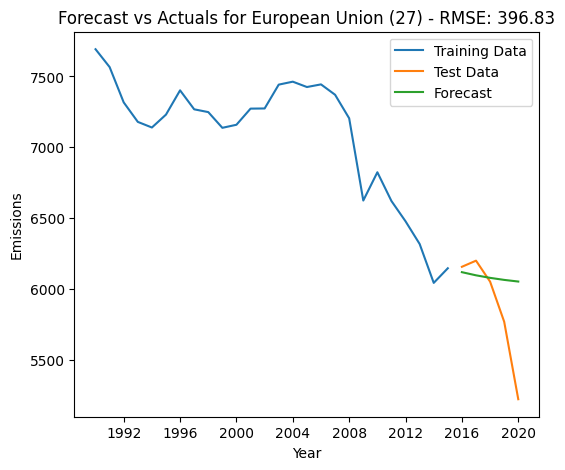

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

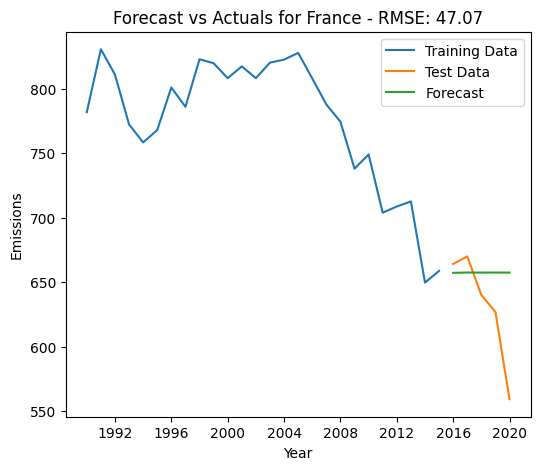

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

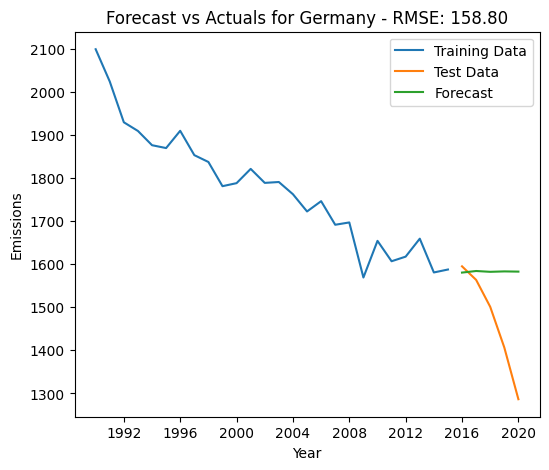

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

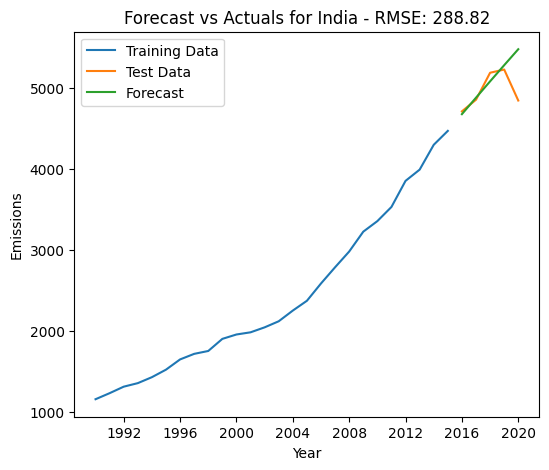

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 640x480 with 0 Axes>

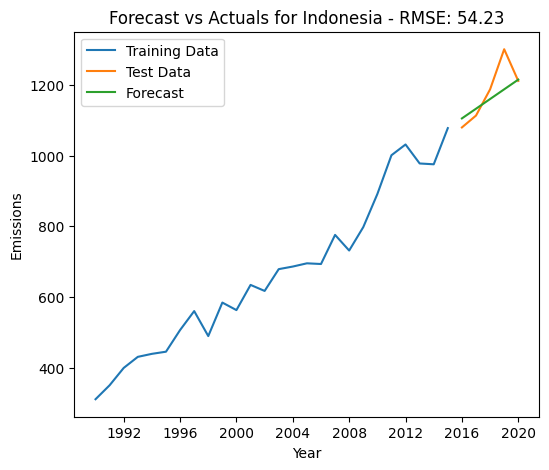

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

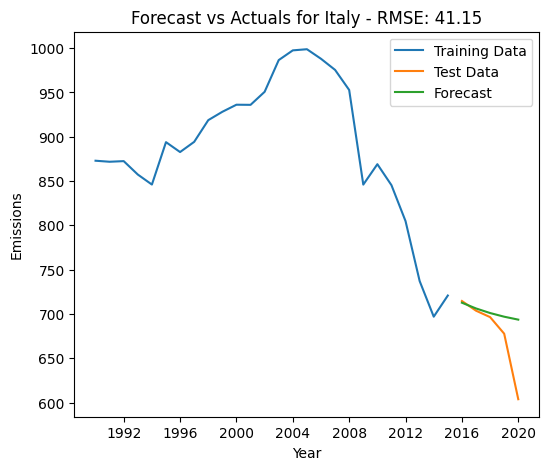

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

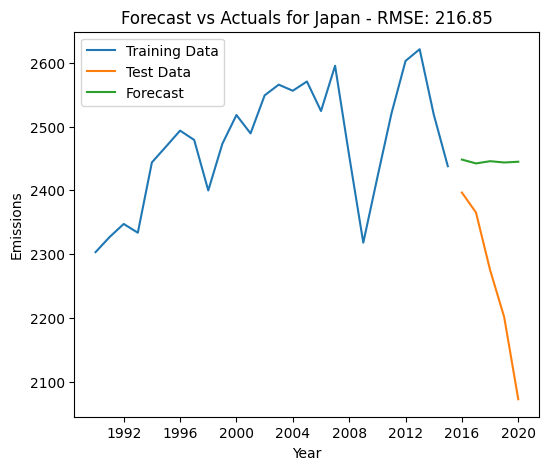

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

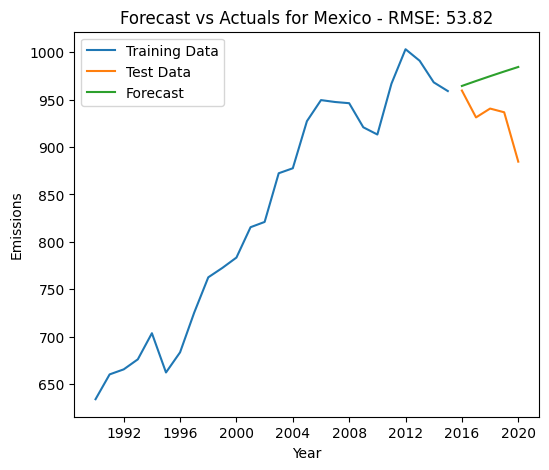

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

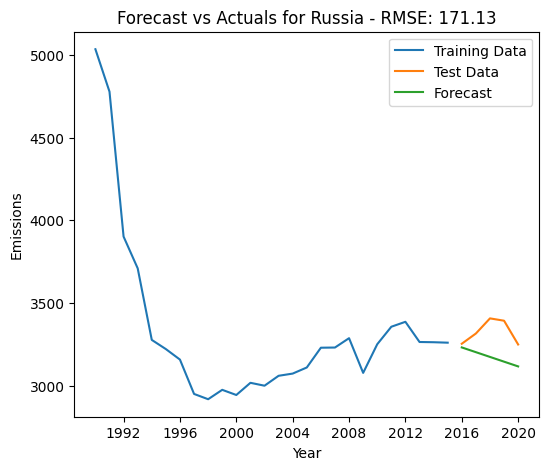

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

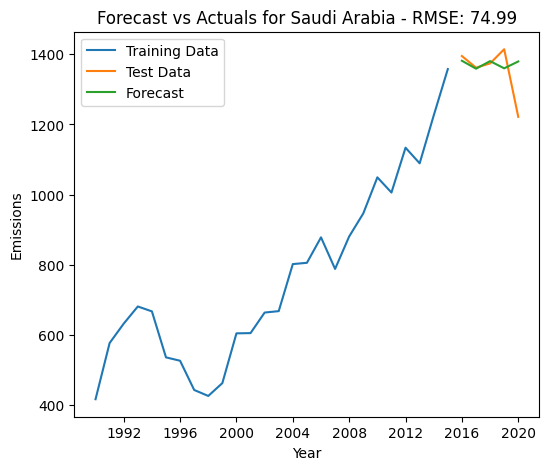

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

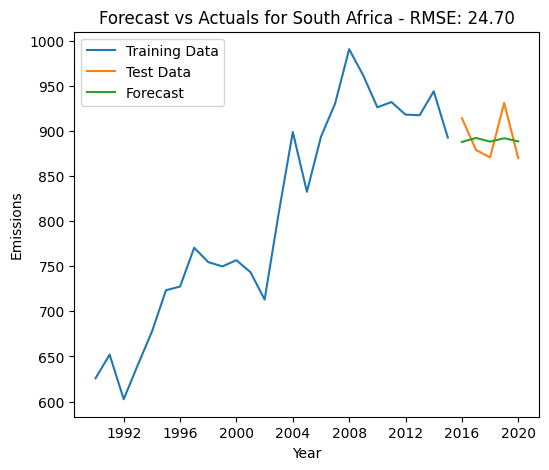

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

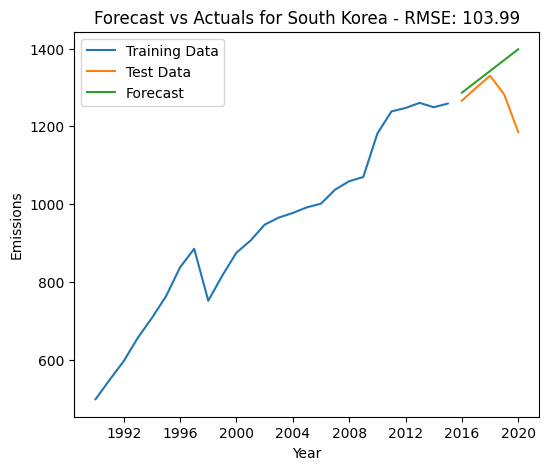

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

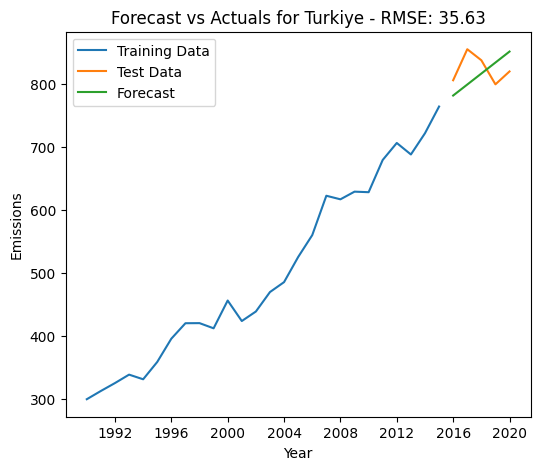

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

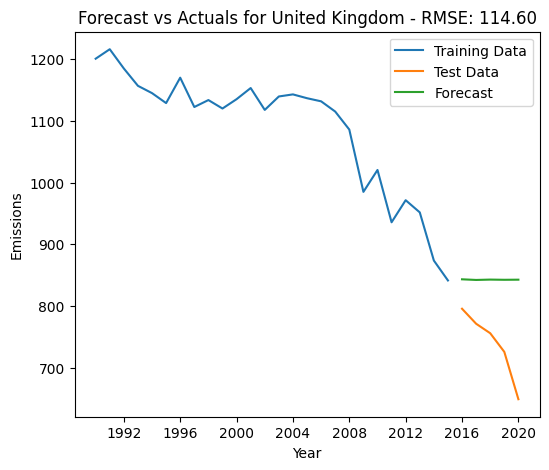

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

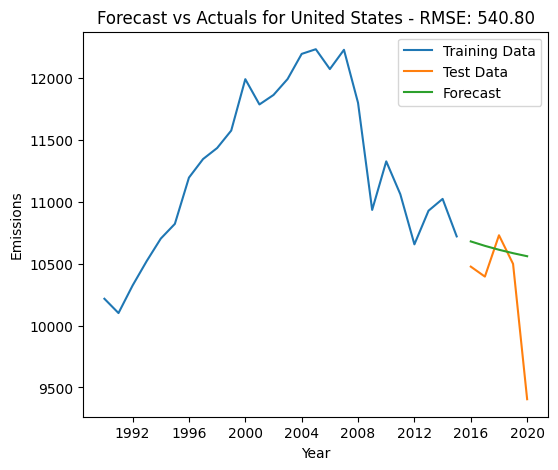

Metrics for Argentina:
  MSE: 842.21
  RMSE: 29.02
  MSLE: 0.01
  MAE: 24.03
  MedAE: 24.10


Metrics for Australia:
  MSE: 390.60
  RMSE: 19.76
  MSLE: 0.00
  MAE: 19.63
  MedAE: 20.57


Metrics for Brazil:
  MSE: 34690.43
  RMSE: 186.25
  MSLE: 0.03
  MAE: 173.33
  MedAE: 171.68


Metrics for Canada:
  MSE: 2259.17
  RMSE: 47.53
  MSLE: 0.00
  MAE: 32.60
  MedAE: 12.73


Metrics for China:
  MSE: 2546280.73
  RMSE: 1595.71
  MSLE: 0.01
  MAE: 1301.82
  MedAE: 1287.68


Metrics for European Union (27):
  MSE: 157475.97
  RMSE: 396.83
  MSLE: 0.00
  MAE: 258.38
  MedAE: 103.23


Metrics for France:
  MSE: 2215.30
  RMSE: 47.07
  MSLE: 0.01
  MAE: 33.10
  MedAE: 17.39


Metrics for Germany:
  MSE: 25216.07
  RMSE: 158.80
  MSLE: 0.01
  MAE: 117.82
  MedAE: 81.27


Metrics for India:
  MSE: 83416.97
  RMSE: 288.82
  MSLE: 0.00
  MAE: 170.59
  MedAE: 53.62


Metrics for Indonesia:
  MSE: 2940.38
  RMSE: 54.23
  MSLE: 0.00
  MAE: 37.95
  MedAE: 25.60


Metrics for Italy:
  MSE: 1693.31
  R

<Figure size 640x480 with 0 Axes>

In [14]:
# Define the ARIMA model parameters
p = 1  # Number of autoregressive terms
d = 1  # Number of differences
q = 1  # Number of moving average terms

results = {}

for country in final_df.columns:
    ts_data = final_df[country]

    # Check if there are enough data points
    if len(ts_data) < 20:
        print(f"Not enough data points for {country}")
        continue

    # Split the data into training and testing sets
    train = ts_data[:-5]
    test = ts_data[-5:]

    # Fit the ARIMA model
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=5)
        forecast_series = pd.Series(forecast, index=test.index)

        # Calculate error metrics
        mse = mean_squared_error(test, forecast_series)
        rmse = np.sqrt(mse)
        msle = mean_squared_log_error(test, forecast_series)
        mae = mean_absolute_error(test, forecast_series)
        medae = median_absolute_error(test, forecast_series)

        # Store the results
        results[country] = {
            'Forecast': forecast_series,
            'Test': test,
            'MSE': mse,
            'RMSE': rmse,
            'MSLE': msle,
            'MAE': mae,
            'MedAE': medae
        }

        # Plotting the results
        plt.figure(figsize=(6, 5))
        plt.plot(train.index, train, label='Training Data')
        plt.plot(test.index, test, label='Test Data')
        plt.plot(forecast_series.index, forecast_series, label='Forecast')
        plt.title(f'Forecast vs Actuals for {country} - RMSE: {rmse:.2f}')
        plt.xlabel('Year')
        plt.ylabel('Emissions')
        plt.legend()
        plt.show()
        plt.tight_layout()

    except Exception as e:
        print(f"Failed to fit ARIMA model for {country}: {e}")

# Print the error metrics for each country
for country, data in results.items():
    print(f"Metrics for {country}:")
    for metric_name, metric_value in data.items():
        if metric_name in ['Forecast', 'Test']:
            continue
        print(f"  {metric_name}: {metric_value:.2f}")
    print("\n")

# **Holt Winter Model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Argentina - Mean Squared Error: 5080.97
Argentina - Root Mean Squared Error: 71.28
Argentina - Mean Squared Log Error: 0.03
Argentina - Mean Absolute Error: 64.30
Argentina - Median Absolute Error: 63.57

Australia - Mean Squared Error: 805.51
Australia - Root Mean Squared Error: 28.38
Australia - Mean Squared Log Error: 0.00
Australia - Mean Absolute Error: 17.86
Australia - Median Absolute Error: 6.81



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Brazil - Mean Squared Error: 35274.32
Brazil - Root Mean Squared Error: 187.81
Brazil - Mean Squared Log Error: 0.03
Brazil - Mean Absolute Error: 172.24
Brazil - Median Absolute Error: 156.02

Canada - Mean Squared Error: 5069.21
Canada - Root Mean Squared Error: 71.20
Canada - Mean Squared Log Error: 0.00
Canada - Mean Absolute Error: 48.81
Canada - Median Absolute Error: 38.05



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


China - Mean Squared Error: 7314398.39
China - Root Mean Squared Error: 2704.51
China - Mean Squared Log Error: 0.02
China - Mean Absolute Error: 2258.81
China - Median Absolute Error: 2198.50

European Union (27) - Mean Squared Error: 79153.30
European Union (27) - Root Mean Squared Error: 281.34
European Union (27) - Mean Squared Log Error: 0.00
European Union (27) - Mean Absolute Error: 239.28
European Union (27) - Median Absolute Error: 246.32



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


France - Mean Squared Error: 3446.90
France - Root Mean Squared Error: 58.71
France - Mean Squared Log Error: 0.01
France - Mean Absolute Error: 52.91
France - Median Absolute Error: 69.50

Germany - Mean Squared Error: 10054.26
Germany - Root Mean Squared Error: 100.27
Germany - Mean Squared Log Error: 0.01
Germany - Mean Absolute Error: 80.14
Germany - Median Absolute Error: 71.43



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


India - Mean Squared Error: 198485.30
India - Root Mean Squared Error: 445.52
India - Mean Squared Log Error: 0.01
India - Mean Absolute Error: 283.43
India - Median Absolute Error: 106.78



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Indonesia - Mean Squared Error: 6050.88
Indonesia - Root Mean Squared Error: 77.79
Indonesia - Mean Squared Log Error: 0.00
Indonesia - Mean Absolute Error: 57.52
Indonesia - Median Absolute Error: 48.88



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Italy - Mean Squared Error: 1001.21
Italy - Root Mean Squared Error: 31.64
Italy - Mean Squared Log Error: 0.00
Italy - Mean Absolute Error: 27.79
Italy - Median Absolute Error: 30.49

Japan - Mean Squared Error: 63997.15
Japan - Root Mean Squared Error: 252.98
Japan - Mean Squared Log Error: 0.01
Japan - Mean Absolute Error: 214.43
Japan - Median Absolute Error: 206.85



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Mexico - Mean Squared Error: 5824.66
Mexico - Root Mean Squared Error: 76.32
Mexico - Mean Squared Log Error: 0.01
Mexico - Mean Absolute Error: 66.21
Mexico - Median Absolute Error: 63.26

Russia - Mean Squared Error: 525049.14
Russia - Root Mean Squared Error: 724.60
Russia - Mean Squared Log Error: 0.06
Russia - Mean Absolute Error: 704.30
Russia - Median Absolute Error: 765.27



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Saudi Arabia - Mean Squared Error: 16371.46
Saudi Arabia - Root Mean Squared Error: 127.95
Saudi Arabia - Mean Squared Log Error: 0.01
Saudi Arabia - Mean Absolute Error: 108.23
Saudi Arabia - Median Absolute Error: 118.08

South Africa - Mean Squared Error: 19226.85
South Africa - Root Mean Squared Error: 138.66
South Africa - Mean Squared Log Error: 0.02
South Africa - Mean Absolute Error: 128.16
South Africa - Median Absolute Error: 125.14



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


South Korea - Mean Squared Error: 17282.17
South Korea - Root Mean Squared Error: 131.46
South Korea - Mean Squared Log Error: 0.01
South Korea - Mean Absolute Error: 92.00
South Korea - Median Absolute Error: 26.92



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Turkiye - Mean Squared Error: 2249.00
Turkiye - Root Mean Squared Error: 47.42
Turkiye - Mean Squared Log Error: 0.00
Turkiye - Mean Absolute Error: 43.98
Turkiye - Median Absolute Error: 50.10



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


United Kingdom - Mean Squared Error: 964.63
United Kingdom - Root Mean Squared Error: 31.06
United Kingdom - Mean Squared Log Error: 0.00
United Kingdom - Mean Absolute Error: 23.64
United Kingdom - Median Absolute Error: 17.36



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


United States - Mean Squared Error: 488523.17
United States - Root Mean Squared Error: 698.94
United States - Mean Squared Log Error: 0.00
United States - Mean Absolute Error: 555.61
United States - Median Absolute Error: 407.40



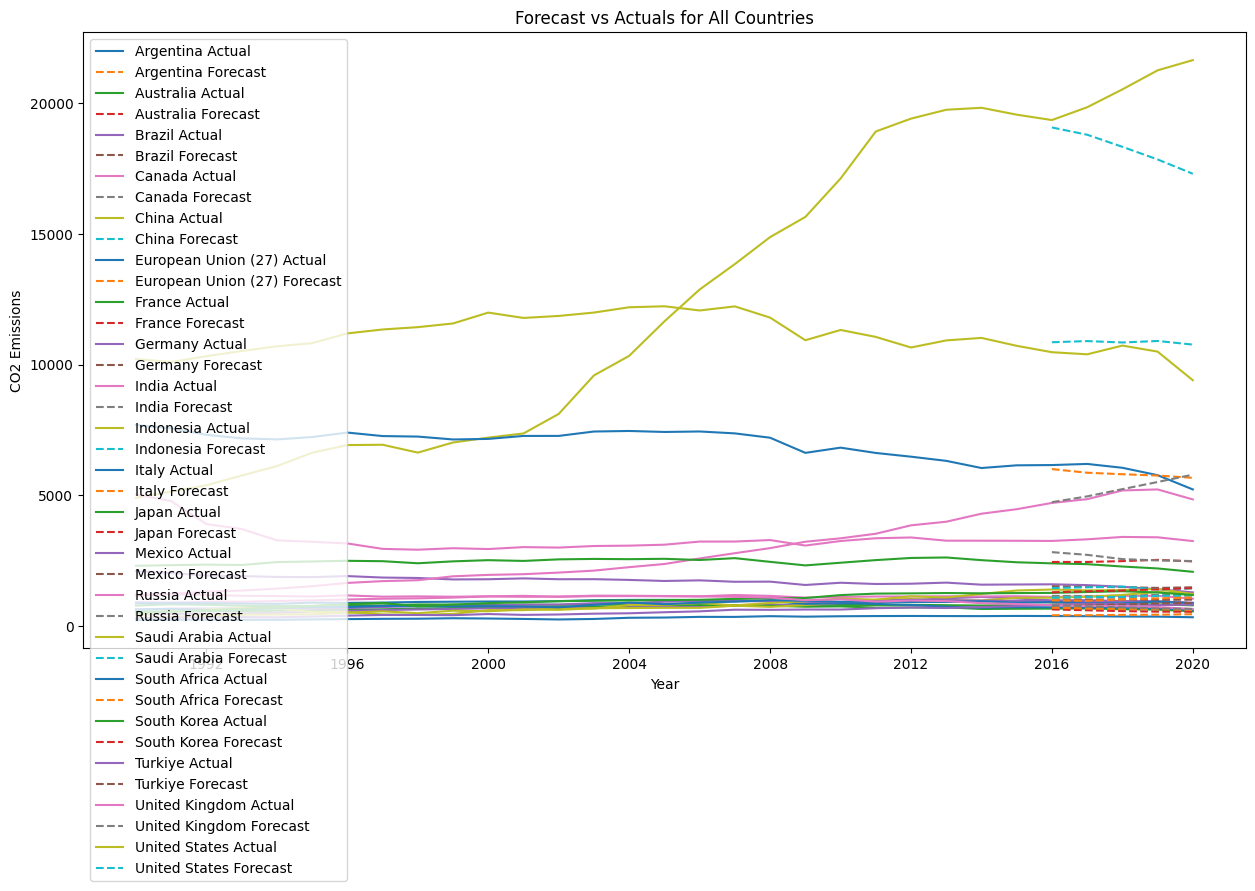

In [15]:
# Initialize a plot with adequate size
plt.figure(figsize=(15, 8))

# Iterate over each column in the DataFrame
for country in final_df.columns:
    ts_data = final_df[country]
    train = ts_data[:-5]  # Training data
    test = ts_data[-5:]   # Testing data

    # Fit the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add', damped_trend=False)
    model_fit = model.fit()

    # Forecast the next 5 years
    forecast = model_fit.forecast(steps=5)

    # Plot each country's historical data and forecast
    plt.plot(ts_data.index, ts_data, label=f'{country} Actual')
    plt.plot(test.index, forecast, label=f'{country} Forecast', linestyle='--')

    # Calculate and print error metrics
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    medae = median_absolute_error(test, forecast)

    print(f'{country} - Mean Squared Error: {mse:.2f}')
    print(f'{country} - Root Mean Squared Error: {rmse:.2f}')
    print(f'{country} - Mean Squared Log Error: {msle:.2f}')
    print(f'{country} - Mean Absolute Error: {mae:.2f}')
    print(f'{country} - Median Absolute Error: {medae:.2f}\n')

# Finalizing the plot
plt.title('Forecast vs Actuals for All Countries')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()

# Linear Regression

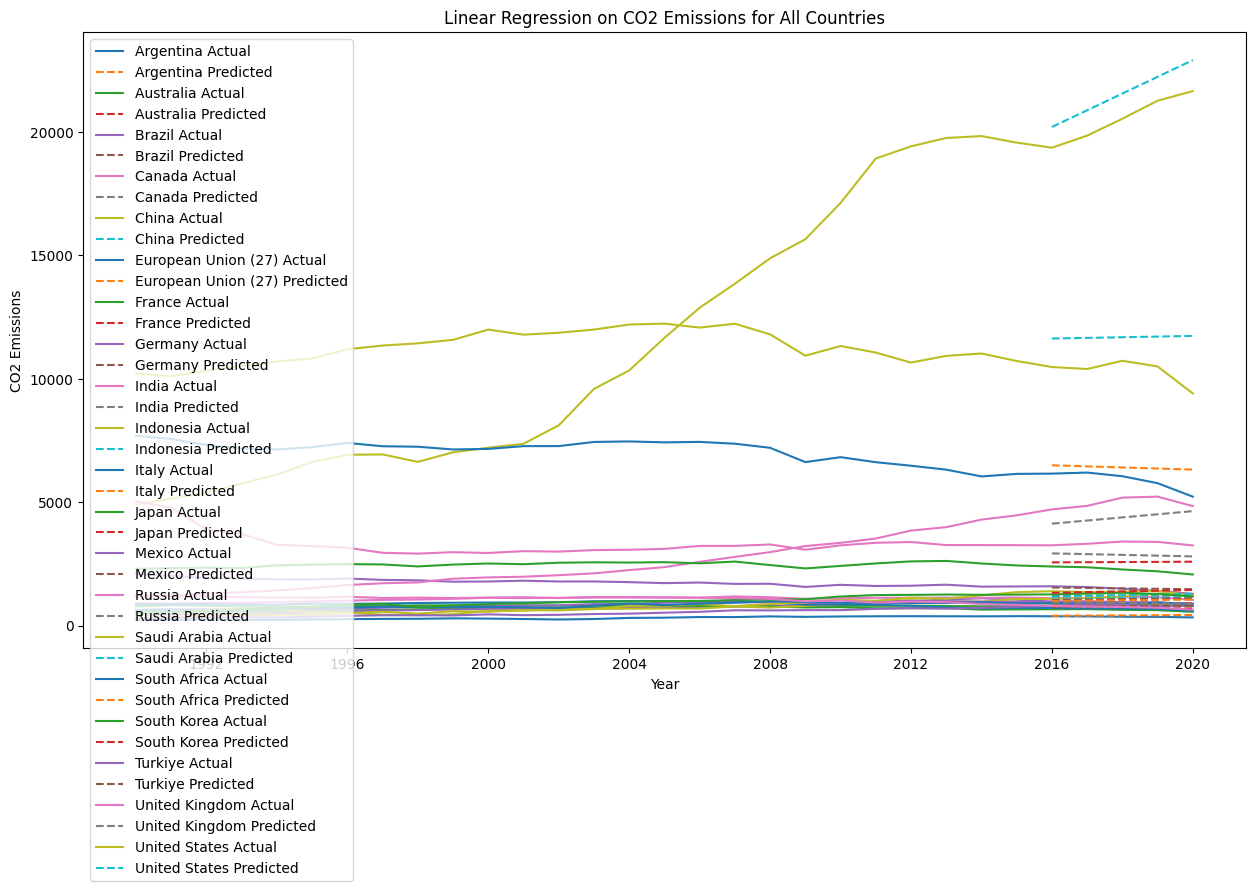

Metrics for Argentina:
  MSE: 3639.93
  RMSE: 60.33
  MSLE: 0.02
  MAE: 54.53
  MedAE: 54.45


Metrics for Australia:
  MSE: 5917.71
  RMSE: 76.93
  MSLE: 0.01
  MAE: 72.23
  MedAE: 62.27


Metrics for Brazil:
  MSE: 27266.13
  RMSE: 165.12
  MSLE: 0.03
  MAE: 149.38
  MedAE: 147.73


Metrics for Canada:
  MSE: 13296.17
  RMSE: 115.31
  MSLE: 0.01
  MAE: 104.99
  MedAE: 83.28


Metrics for China:
  MSE: 1062624.36
  RMSE: 1030.84
  MSLE: 0.00
  MAE: 1022.09
  MedAE: 1020.24


Metrics for European Union (27):
  MSE: 371592.18
  RMSE: 609.58
  MSLE: 0.01
  MAE: 526.97
  MedAE: 355.27


Metrics for France:
  MSE: 6670.22
  RMSE: 81.67
  MSLE: 0.02
  MAE: 74.21
  MedAE: 66.23


Metrics for Germany:
  MSE: 9409.67
  RMSE: 97.00
  MSLE: 0.00
  MAE: 74.20
  MedAE: 50.86


Metrics for India:
  MSE: 376162.35
  RMSE: 613.32
  MSLE: 0.02
  MAE: 578.34
  MedAE: 595.14


Metrics for Indonesia:
  MSE: 7493.86
  RMSE: 86.57
  MSLE: 0.01
  MAE: 70.46
  MedAE: 46.22


Metrics for Italy:
  MSE: 24717.3

In [16]:
# Dictionary to store error metrics for each country
error_metrics = {}

plt.figure(figsize=(15, 8))

# Loop through each country column and fit the linear regression model
for country in final_df.columns:
    ts_data = final_df[country]
    X = np.array(ts_data.index.year).reshape(-1, 1)
    y = ts_data.values

    # Split the data into training and testing sets
    train_X, test_X = X[:-5], X[-5:]
    train_y, test_y = y[:-5], y[-5:]

    # Fit linear regression model
    model = LinearRegression()
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)

    # Calculate error metrics
    mse = mean_squared_error(test_y, predictions)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(test_y, predictions)
    mae = mean_absolute_error(test_y, predictions)
    medae = median_absolute_error(test_y, predictions)
    error_metrics[country] = {
        'MSE': mse,
        'RMSE': rmse,
        'MSLE': msle,
        'MAE': mae,
        'MedAE': medae
    }

    # Plot the actual vs predicted for the test set
    plt.plot(ts_data.index, y, label=f'{country} Actual')
    plt.plot(ts_data.index[-5:], predictions, linestyle='--', label=f'{country} Predicted')

# plot
plt.title('Linear Regression on CO2 Emissions for All Countries')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()

# Display the error metrics for each country
for country, metrics in error_metrics.items():
    print(f"Metrics for {country}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")
    print("\n")

# Random Forest

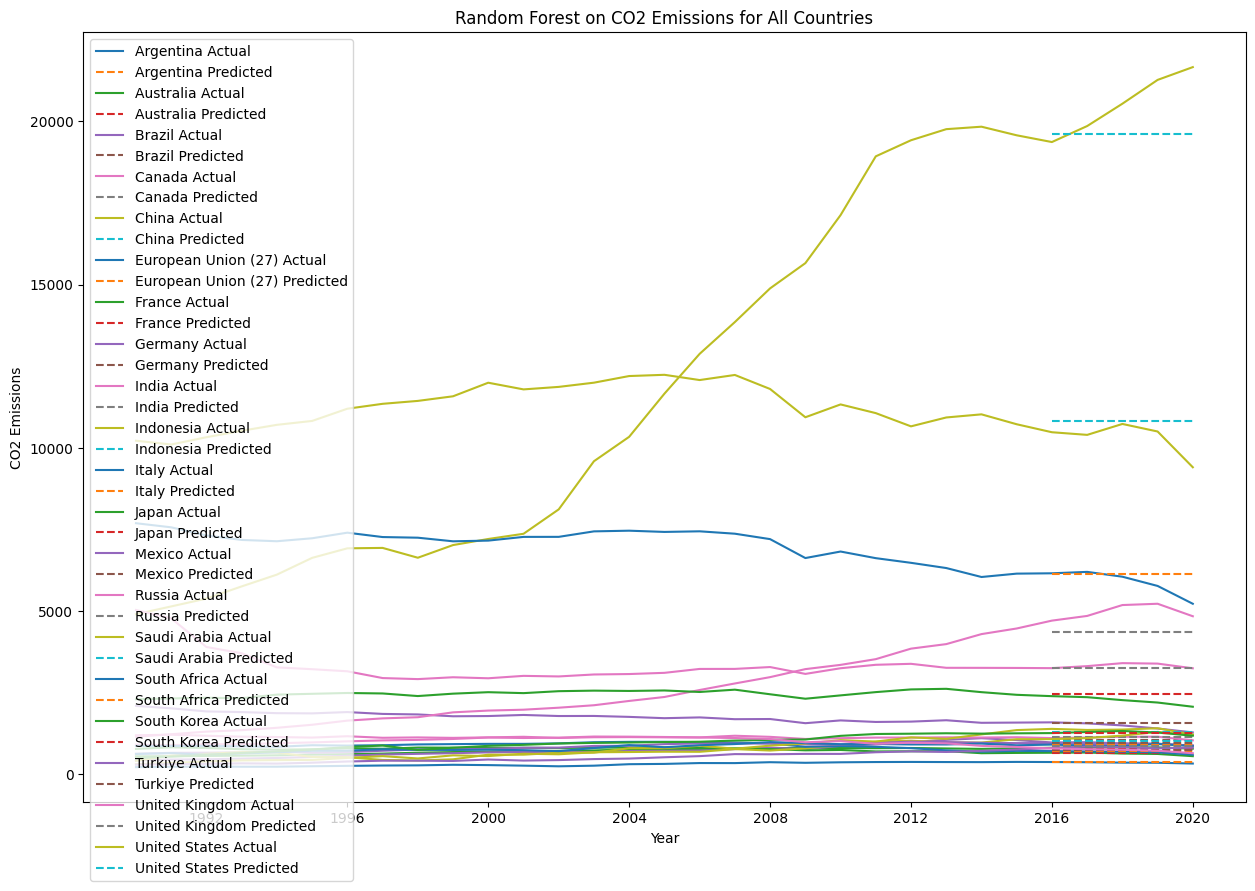

Metrics for Argentina:
  MSE: 647.61
  RMSE: 25.45
  MSLE: 0.00
  MAE: 19.81
  MedAE: 19.73


Metrics for Australia:
  MSE: 733.55
  RMSE: 27.08
  MSLE: 0.00
  MAE: 24.74
  MedAE: 29.66


Metrics for Brazil:
  MSE: 15414.92
  RMSE: 124.16
  MSLE: 0.02
  MAE: 118.48
  MedAE: 116.82


Metrics for Canada:
  MSE: 1926.02
  RMSE: 43.89
  MSLE: 0.00
  MAE: 30.96
  MedAE: 19.44


Metrics for China:
  MSE: 1565641.47
  RMSE: 1251.26
  MSLE: 0.00
  MAE: 1018.62
  MedAE: 917.99


Metrics for European Union (27):
  MSE: 194555.61
  RMSE: 441.08
  MSLE: 0.01
  MAE: 289.03
  MedAE: 81.74


Metrics for France:
  MSE: 2381.54
  RMSE: 48.80
  MSLE: 0.01
  MAE: 33.68
  MedAE: 20.49


Metrics for Germany:
  MSE: 26848.08
  RMSE: 163.85
  MSLE: 0.01
  MAE: 121.42
  MedAE: 88.98


Metrics for India:
  MSE: 394629.27
  RMSE: 628.20
  MSLE: 0.02
  MAE: 593.89
  MedAE: 483.61


Metrics for Indonesia:
  MSE: 25919.78
  RMSE: 161.00
  MSLE: 0.02
  MAE: 140.95
  MedAE: 149.94


Metrics for Italy:
  MSE: 2971.49

In [17]:
# Dictionary to store error metrics for each country
error_metrics = {}

# Set up a figure for plotting all countries together
plt.figure(figsize=(15, 10))

# Loop through each country column and fit the random forest model
for country in final_df.columns:
    ts_data = final_df[country]
    X = np.array(ts_data.index.year).reshape(-1, 1)
    y = ts_data.values

    # Split the data into training and testing sets
    train_X, test_X = X[:-5], X[-5:]
    train_y, test_y = y[:-5], y[-5:]

    # Fit random forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)

    # Calculate error metrics
    mse = mean_squared_error(test_y, predictions)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(test_y, predictions)
    mae = mean_absolute_error(test_y, predictions)
    medae = median_absolute_error(test_y, predictions)
    error_metrics[country] = {
        'MSE': mse,
        'RMSE': rmse,
        'MSLE': msle,
        'MAE': mae,
        'MedAE': medae
    }

    # Plot the actual vs predicted for the test set
    plt.plot(ts_data.index, y, label=f'{country} Actual')
    plt.plot(ts_data.index[-5:], predictions, linestyle='--', label=f'{country} Predicted')

# plot
plt.title('Random Forest on CO2 Emissions for All Countries')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()

# Display the error metrics for each country
for country, metrics in error_metrics.items():
    print(f"Metrics for {country}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")
    print("\n")


# LSTM

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


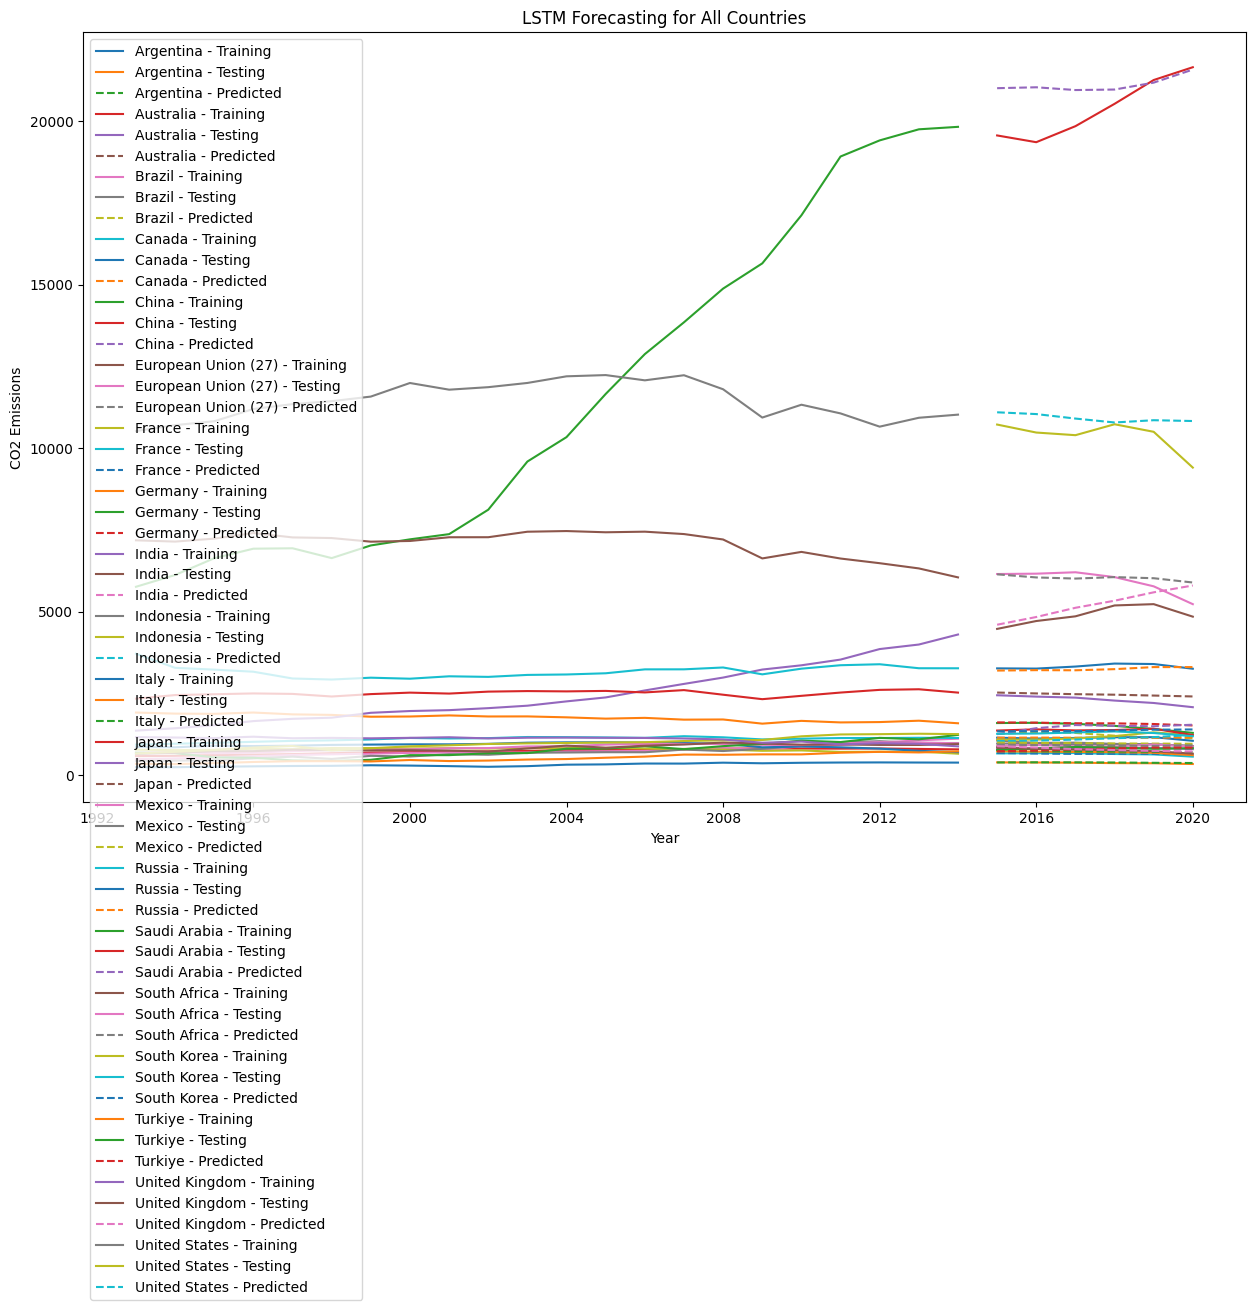

Metrics for Argentina:
  MSE: 274.68
  RMSE: 16.57
  MSLE: 0.00
  MAE: 13.61
  MedAE: 12.11


Metrics for Australia:
  MSE: 341.54
  RMSE: 18.48
  MSLE: 0.00
  MAE: 16.80
  MedAE: 18.52


Metrics for Brazil:
  MSE: 66125.34
  RMSE: 257.15
  MSLE: 0.06
  MAE: 252.58
  MedAE: 244.86


Metrics for Canada:
  MSE: 2064.54
  RMSE: 45.44
  MSLE: 0.00
  MAE: 28.30
  MedAE: 14.34


Metrics for China:
  MSE: 1056737.36
  RMSE: 1027.98
  MSLE: 0.00
  MAE: 803.62
  MedAE: 771.37


Metrics for European Union (27):
  MSE: 91953.67
  RMSE: 303.24
  MSLE: 0.00
  MAE: 204.78
  MedAE: 154.05


Metrics for France:
  MSE: 1053.42
  RMSE: 32.46
  MSLE: 0.00
  MAE: 23.78
  MedAE: 13.07


Metrics for Germany:
  MSE: 13525.16
  RMSE: 116.30
  MSLE: 0.01
  MAE: 82.86
  MedAE: 48.40


Metrics for India:
  MSE: 193531.60
  RMSE: 439.92
  MSLE: 0.01
  MAE: 328.75
  MedAE: 203.12


Metrics for Indonesia:
  MSE: 4897.96
  RMSE: 69.99
  MSLE: 0.00
  MAE: 54.37
  MedAE: 37.48


Metrics for Italy:
  MSE: 1622.38
  RMS

In [18]:
# Set up a figure for plotting all countries together
plt.figure(figsize=(15, 10))

# LSTM needs input shape [samples, timesteps, features]
def create_dataset(series, look_back=1):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i + look_back)])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

# Loop through each country column
error_metrics = {}
look_back = 3  # Define the window size

for country in final_df.columns:
    ts_data = final_df[country].dropna()

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    ts_data_scaled = scaler.fit_transform(ts_data.values.reshape(-1, 1))

    # Prepare the data
    X, y = create_dataset(ts_data_scaled, look_back)
    train_size = int(len(X) * 0.8)
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size], y[train_size:]

    # Reshape input to be [samples, timesteps, features]
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=0)

    # Make predictions
    train_predict = model.predict(train_X)
    test_predict = model.predict(test_X)

    # Invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Invert actual values
    train_y = scaler.inverse_transform(train_y.reshape(-1, 1))
    test_y = scaler.inverse_transform(test_y.reshape(-1, 1))

    # Determine the appropriate indices for train and test
    train_indices = ts_data.index[look_back:train_size + look_back]
    test_indices = ts_data.index[train_size + look_back:]

    # Plot the actual vs predicted
    plt.plot(train_indices, train_y.flatten(), label=f'{country} - Training')
    plt.plot(test_indices, test_y.flatten(), label=f'{country} - Testing')
    plt.plot(test_indices, test_predict.flatten(), linestyle='--', label=f'{country} - Predicted')

    # Calculate error metrics
    mse = mean_squared_error(test_y.flatten(), test_predict.flatten())
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(test_y.flatten(), test_predict.flatten())
    mae = mean_absolute_error(test_y.flatten(), test_predict.flatten())
    medae = median_absolute_error(test_y.flatten(), test_predict.flatten())
    error_metrics[country] = {
        'MSE': mse,
        'RMSE': rmse,
        'MSLE': msle,
        'MAE': mae,
        'MedAE': medae
    }

# display the plot
plt.title('LSTM Forecasting for All Countries')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()

# Display the error metrics for each country
for country, metrics in error_metrics.items():
    print(f"Metrics for {country}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")
    print("\n")

# I observed that LSTM is performing better than all other models so I'm Predicting C02 Emissions for next 10 years till 2030 using LSTM

1/1 [==============================] - 0s 21ms/step


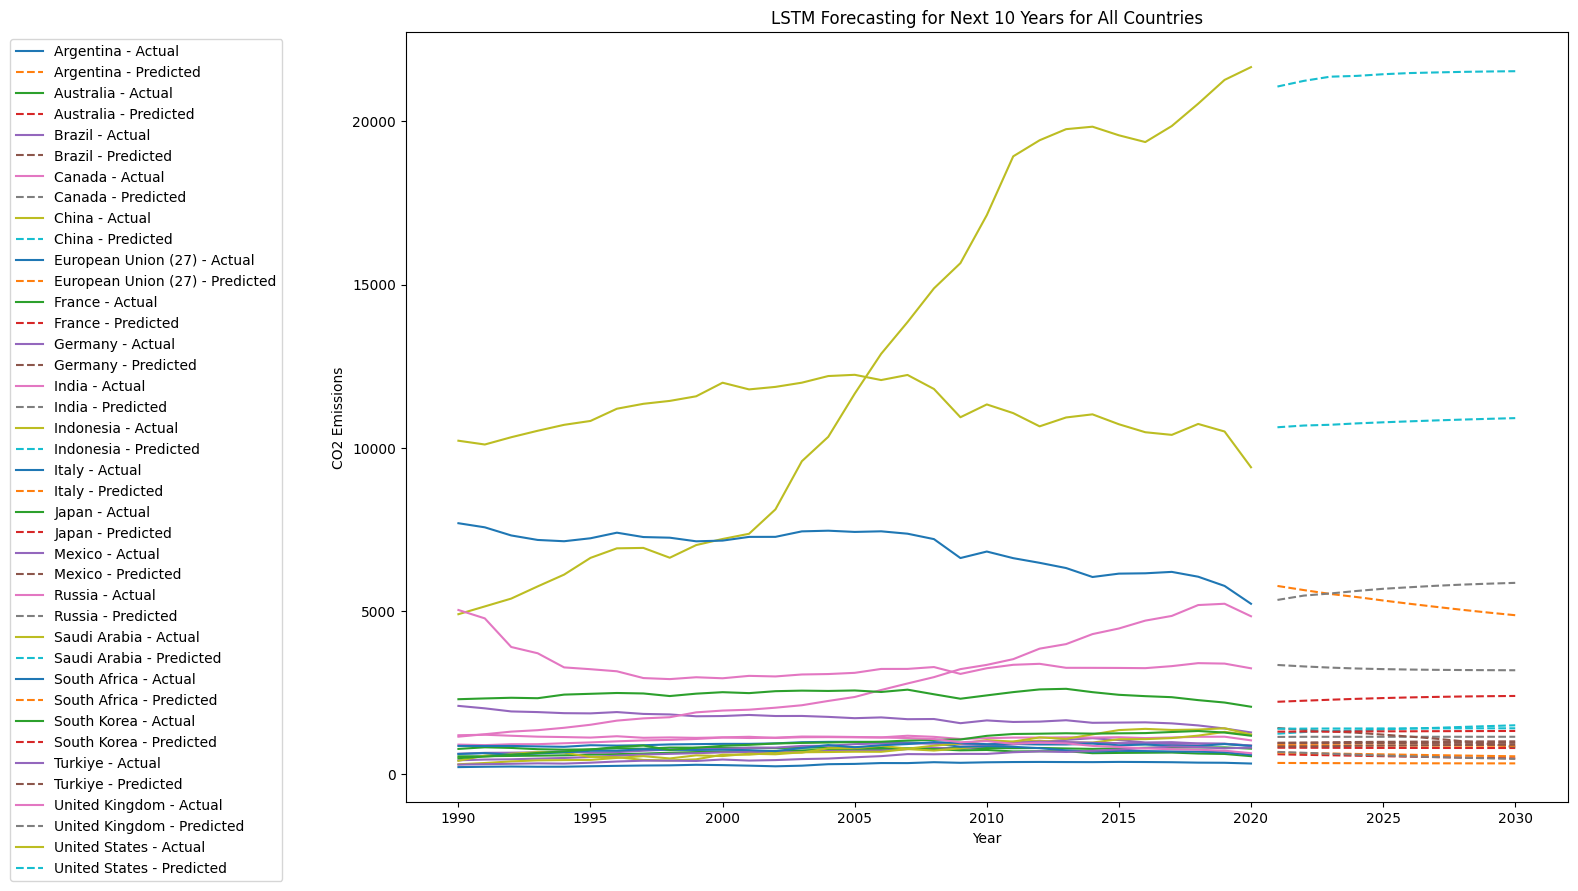

Future Predictions for the Next 10 Years (2021-2030):
             Argentina   Australia       Brazil       Canada         China  \
2021-01-01  351.886445  817.658517   970.823939  1149.172385  21061.744120   
2022-01-01  348.707806  816.566392   977.751815  1152.581488  21235.410767   
2023-01-01  346.060186  814.934665   985.832013  1152.868933  21363.714815   
2024-01-01  344.098544  812.541763   993.495606  1152.365754  21387.652138   
2025-01-01  342.537823  811.608546   998.846577  1152.967816  21438.672831   
2026-01-01  341.313429  810.717356  1003.209796  1153.058248  21474.031176   
2027-01-01  340.334654  809.924024  1006.653510  1153.079695  21493.280877   
2028-01-01  339.550894  809.439077  1009.312558  1153.213963  21510.584641   
2029-01-01  338.919263  809.036685  1011.383863  1153.261279  21522.761474   
2030-01-01  338.408775  808.720566  1012.987317  1153.296989  21530.981536   

            European Union (27)      France      Germany        India  \
2021-01-01    

In [19]:
# Set up a figure for plotting all countries together
plt.figure(figsize=(15, 10))

# LSTM needs input shape [samples, timesteps, features]
def create_dataset(series, look_back=1):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i + look_back)])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

# Loop through each country column
error_metrics = {}
look_back = 3  # Define the window size
future_years = 10
next_year = 2021
predictions = pd.DataFrame()

for country in final_df.columns:
    ts_data = final_df[country].dropna()

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    ts_data_scaled = scaler.fit_transform(ts_data.values.reshape(-1, 1))

    # Prepare the data
    X, y = create_dataset(ts_data_scaled, look_back)
    train_size = int(len(X))
    train_X, train_y = X[:train_size], y[:train_size]

    # Reshape input to be [samples, timesteps, features]
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=0)

    # Make predictions for the next 10 years
    future_predictions = []
    last_values = train_X[-1]

    for _ in range(future_years):
        next_value = model.predict(last_values[np.newaxis, :, :])[0]
        future_predictions.append(next_value)
        last_values = np.roll(last_values, -1)
        last_values[-1] = next_value

    # Invert predictions
    future_predictions = scaler.inverse_transform(future_predictions)

    # Store predictions
    future_years_index = [pd.to_datetime(f"{next_year + i}-01-01") for i in range(future_years)]
    predictions[country] = pd.Series(future_predictions.flatten(), index=future_years_index)

    # Plot the actual vs predicted
    plt.plot(ts_data.index, ts_data.values, label=f'{country} - Actual')
    plt.plot(future_years_index, future_predictions.flatten(), linestyle='--', label=f'{country} - Predicted')

plt.title('LSTM Forecasting for Next 10 Years for All Countries')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend(bbox_to_anchor=(-0.1, 1), loc='upper right', ncol=1)
plt.show()

# Display the predictions
print("Future Predictions for the Next 10 Years (2021-2030):")
print(predictions)